In [2]:
%load_ext autoreload
%autoreload 2
import pinot
import matplotlib
from matplotlib import pyplot as plt
import torch
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def f(x):
    """ Example from
    https://pyro.ai/examples/bo.html
    """
    return (6 * x - 2)**2 * torch.sin(12 * x - 4)

x = torch.linspace(0, 1)
y = f(x)

In [4]:
net = pinot.inference.gp.gpr.exact_gpr.ExactGPR(
    kernel=pinot.inference.gp.kernels.deep_kernel.DeepKernel(
        base_kernel=pinot.inference.gp.kernels.rbf.RBF(),
        representation=torch.nn.Sequential(
            torch.nn.Linear(1, 50),
            torch.nn.Tanh())))

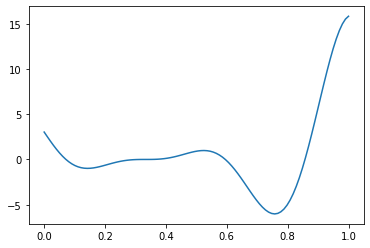

In [5]:
plt.plot(x, y)

In [11]:
bo = pinot.active.experiment.SingleTaskBayesianOptimizationExperiment(
        net=net,
        data=torch.stack([x, y], dim=1),
        optimizer=torch.optim.Adam(net.parameters(), 1e-3),
        acquisition=pinot.active.acquisition.expected_improvement,
        n_epochs_training=10)



In [12]:
dists = []

In [13]:
limit = 9999
idx = 0
bo.blind_pick()

while idx < limit and len(bo.new) > 0:
    bo.train()
    bo.acquire()
    idx += 1
    dists.append(bo.net.condition(x[:, None]))
    

In [14]:
import gif
@gif.frame
def plot(idx):
    old = bo.old
    plt.figure()
    plt.plot(x, y)
    plt.scatter(x[old[:idx]], y[old[:idx]])
    
    dist = dists[idx]
    
    from pinot.inference.utils import confidence_interval
    
    low, high = confidence_interval(dist, 0.95, n_samples=100)
    plt.fill_between(
        x.flatten().detach(), 
        low.flatten().detach(), 
        high.flatten().detach(), 
        color='k', 
        alpha=0.1)
    
    low, high = confidence_interval(dist, 0.75, n_samples=100)
    plt.fill_between(
        x.flatten().detach(), 
        low.flatten().detach(), 
        high.flatten().detach(), 
        color='k', 
        alpha=0.2)
    
    low, high = confidence_interval(dist, 0.50, n_samples=100)
    plt.fill_between(
        x.flatten().detach(), 
        low.flatten().detach(), 
        high.flatten().detach(), 
        color='k', 
        alpha=0.3)
    
    low, high = confidence_interval(dist, 0.20, n_samples=100)
    plt.fill_between(
        x.flatten().detach(), 
        low.flatten().detach(), 
        high.flatten().detach(), 
        color='k', 
        alpha=0.4)
    
    plt.ylim(-10, 20)
    
    
    

In [15]:
frames = [plot(idx) for idx in range(len(dists))]
gif.save(frames, "adam.gif", duration=100)